In [36]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from load_data import load_heart_data, load_tweet_data

In [21]:
train_X, test_X, train_y, test_y = load_heart_data("heart_dataset.csv")

In [22]:
print("Shape of Train X: ", train_X.shape, ", Type: ", type(train_X))
print("Shape of Test X: ", test_X.shape, ", Type: ", type(test_X))
print("Shape of Train y: ", train_y.shape, ", Type: ", type(train_y))
print("Shape of Test y: ", test_y.shape, ", Type: ", type(test_y))

Shape of Train X:  (820, 13) , Type:  <class 'numpy.ndarray'>
Shape of Test X:  (205, 13) , Type:  <class 'numpy.ndarray'>
Shape of Train y:  (820,) , Type:  <class 'numpy.ndarray'>
Shape of Test y:  (205,) , Type:  <class 'numpy.ndarray'>


# Baseline Performance

Before testing out the new method explored in the project regarding the locally weighted trees, we will first test out the existing method we aim to improve upon, the random forest model.

In [4]:
# To find the best random forrest model, we need to tune the hyperparameters. Will do 
# so by performing a grid search 

grid_search_parameters = {'max_depth':[5, 10, 15, 30, 50, None], 
                          'n_estimators':[10, 25, 50, 100, 250, 500, 1000], 
                          'max_samples': [0.3, 0.5, 0.7, 0.8, 0.9, 1]}


In [ ]:
random_forest_classifier = RandomForestClassifier(random_state=0)
random_forest_classifier_GS = GridSearchCV(random_forest_classifier, grid_search_parameters, cv=10, verbose=0)
random_forest_classifier_GS.fit(train_X, train_y)


In [ ]:
print("Best Parameters: ", random_forest_classifier_GS.best_params_)
print("Best Score: ", random_forest_classifier_GS.best_score_)

Best Parameters:  {'max_depth': 10, 'max_samples': 0.9, 'n_estimators': 50}
Best Score:  0.9902439024390244


In [ ]:
# Train the model with the best parameters:
random_forest_classifier = RandomForestClassifier(random_state=0, n_estimators=50, max_samples=0.9, max_depth=10)
random_forest_classifier.fit(train_X, train_y)
predictions = random_forest_classifier.predict(test_X)

print(classification_report(test_y, predictions, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.97222   0.98592       108
           1    0.97000   1.00000   0.98477        97

    accuracy                        0.98537       205
   macro avg    0.98500   0.98611   0.98534       205
weighted avg    0.98580   0.98537   0.98537       205



# Locally Weighted Random Forest

In [23]:
from locallyWeightedRandomForest import LocallyWeightedRandomForest
from sklearn.utils.estimator_checks import check_estimator

# Distance functions

TODO move to a separate file, here for easier testing (for now) 

In [35]:
def euclidean_distance(x_1:np.ndarray, x_2:np.ndarray) -> float:
    return np.linalg.norm(x_1 - x_2)

def manhattan_distance(x_1:np.ndarray, x_2:np.ndarray) -> float:
    return np.linalg.norm(x_1 - x_2, ord=1)

def mean_distance(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1)-> float:
    distance_sum = 0
    for p in dataset:
        distance_sum += distance_function(point, p)
    return distance_sum/len(dataset)

def distance_to_dataset_mean(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1)-> float:
    mean_dataset_point = np.mean(dataset, axis=0)
    return distance_function(point, mean_dataset_point)

def median_distance(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1)-> float:
    distances = []
    for p in dataset:
        distances.append(distance_function(point, p))
    return statistics.median(distances)

def nearest_k_distance_mean(k:int) -> callable:
    def _smallest_k_distances_mean(point:np.ndarray, dataset:np.ndarray, distance_function:callable = lambda a,b: 1) -> float:
        distances = np.zeros(len(dataset))
        for i in range(len(dataset)):
            distances[i] = distance_function(point, dataset[i])
        smallest_k_distaces = np.sort(distances)[:k]
        return np.mean(smallest_k_distaces, axis=0)

    return _smallest_k_distances_mean

In [25]:
# lwrf = LocallyWeightedRandomForest(n_estimators=50, max_samples=0.9, max_depth=10)
lwrf = LocallyWeightedRandomForest(n_estimators=50, max_samples=0.9, max_depth=10)
#TODO: lwrf class should allow execution of predict independent of execution of fit
#check_estimator(lwrf)

In [26]:
lwrf.fit(train_X, train_y)

In [27]:
pred = lwrf.predict(test_X, temperature=1)
print(classification_report(test_y, pred, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.97222   0.98592       108
           1    0.97000   1.00000   0.98477        97

    accuracy                        0.98537       205
   macro avg    0.98500   0.98611   0.98534       205
weighted avg    0.98580   0.98537   0.98537       205



In [28]:
pred = lwrf.predict(test_X, temperature=0.15, distance_function=euclidean_distance, distance_aggregation_function=mean_distance)
print(classification_report(test_y, pred, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.97222   0.98592       108
           1    0.97000   1.00000   0.98477        97

    accuracy                        0.98537       205
   macro avg    0.98500   0.98611   0.98534       205
weighted avg    0.98580   0.98537   0.98537       205



In [29]:
#TODO move to separate file 

def cross_validation(X, y, model, temperature, distance_function, distance_agg_func, folds=10, verbose=False):
    k_folds = KFold(n_splits=folds)
    validation_scores = []

    for train_index, val_index in k_folds.split(X):
        train_X, val_X = X[train_index], X[val_index]
        train_y, val_y = y[train_index], y[val_index]


        model.fit(train_X, train_y)
        predictions = model.predict(val_X, temperature, distance_function, distance_agg_func)

        accuracy = accuracy_score(val_y, predictions)

        if verbose:
            print("Fold Accuracy: ", accuracy)

        validation_scores.append(accuracy)

    return np.mean(np.array(validation_scores))

In [65]:

def cross_validation_temperature_range(X, y, model, temperature_list, distance_function, distance_agg_func, folds=10, verbose=False):
    k_folds = KFold(n_splits=folds)
    validation_scores = []

    for train_index, val_index in k_folds.split(X):
        train_X, val_X = X[train_index], X[val_index]
        train_y, val_y = y[train_index], y[val_index]


        model.fit(train_X, train_y)

        temperate_accuracy = []

        for temperature in temperature_list:

            predictions = model.predict(val_X, temperature, distance_function, distance_agg_func)
            accuracy = accuracy_score(val_y, predictions)
            temperate_accuracy.append(accuracy)

        if verbose:
            print("Fold Accuracy: ")
            for i, temp in enumerate(temperature_list):
                print("Temp: ", temp, ", fold acc: ", temperate_accuracy[i])

        validation_scores.append(temperate_accuracy)

    return np.mean(np.array(validation_scores), axis=0)

In [62]:
x = [[1,10,2], [2,20,-1]]
np.mean(np.array(x), axis=0)

array([ 1.5, 15. ,  0.5])

# Experiments

### Comparing sample sizes vs performance 

For this graph, we will keep the number of estimators constant at 300. 

In [82]:
train_X[[1,2,1]]

array([[ 0.94463856,  0.66150409, -0.91575542, -0.09205458,  1.6289381 ,
         2.38733039, -1.00404855, -0.74427134,  1.40392824,  0.62026416,
         0.99543334,  2.17981673,  1.08985168],
       [-0.26843658,  0.66150409,  0.05593123,  0.13641017, -0.87264541,
        -0.41887792,  0.89125488,  0.38643389, -0.71228712, -0.23117653,
         0.99543334,  0.23862459, -0.52212231],
       [ 0.94463856,  0.66150409, -0.91575542, -0.09205458,  1.6289381 ,
         2.38733039, -1.00404855, -0.74427134,  1.40392824,  0.62026416,
         0.99543334,  2.17981673,  1.08985168]])

In [37]:
euc_mean_acc = []
euc_median_acc = []
euc_dataset_mean = []
k_5_euc_mean_acc = []
k_10_euc_mean_acc = []
k_20_euc_mean_acc = []
k_50_euc_mean_acc = []
manhattan_mean_acc = []


In [56]:
k_1_euc_mean_acc = []


In [ ]:
# For the random forest, we will try various values for the portion of the population we 
# sample the data from 
sample_sizes = np.arange(0.1, 1.01, 0.1)

for size in sample_sizes:
    lwrf = LocallyWeightedRandomForest(n_estimators=300, max_samples=size, max_depth=10)
    euc_mean_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=mean_distance, distance_function=euclidean_distance, folds=5, verbose=True))
    euc_median_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=mean_distance, distance_function=euclidean_distance, folds=5, verbose=True))


In [51]:

for size in sample_sizes:
    lwrf = LocallyWeightedRandomForest(n_estimators=300, max_samples=size, max_depth=10)
    k_5_euc_mean_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=nearest_k_distance_mean(k=5), distance_function=euclidean_distance, folds=5, verbose=True))
    k_10_euc_mean_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=nearest_k_distance_mean(k=10), distance_function=euclidean_distance, folds=5, verbose=True))
    k_20_euc_mean_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=nearest_k_distance_mean(k=20), distance_function=euclidean_distance, folds=5, verbose=True))


Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9390243902439024
Fold Accuracy:  0.9329268292682927
Fold Accuracy:  0.8475609756097561
Fold Accuracy:  0.9329268292682927
Fold Accuracy:  0.9573170731707317
Fold Accuracy:  0.8658536585365854
Fold Accuracy:  0.8963414634146342
Fold Accuracy:  0.8353658536585366
Fold Accuracy:  0.9085365853658537
Fold Accuracy:  0.9390243902439024
Fold Accuracy:  0.8780487804878049
Fold Accuracy:  0.9024390243902439
Fold Accuracy:  0.823170731707317
Fold Accuracy:  0.9390243902439024
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9817073170731707
Fold Accuracy:  0.9146341463414634
Fold Accuracy:  0.9695121951219512
Fold Accuracy:  0.9573170731707317
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9329268292682927
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9451219512195121
Fold Accuracy:  0.9573170731707317
Fold Accuracy:  0.932

In [57]:

for size in sample_sizes:
    lwrf = LocallyWeightedRandomForest(n_estimators=300, max_samples=size, max_depth=10)
    k_1_euc_mean_acc.append(cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=nearest_k_distance_mean(k=1), distance_function=euclidean_distance, folds=5, verbose=True))


Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.926829268292683
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9573170731707317
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.9512195121951219
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.9695121951219512
Fold Accuracy:  1.0
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  1.0
Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9878

In [42]:
from sklearn.model_selection import cross_val_score

In [48]:
random_forest_acc = []
for size in sample_sizes:
    model = RandomForestClassifier(random_state=0, n_estimators=300, max_samples=size, max_depth=10)
    random_forest_acc.append(np.mean(cross_val_score(model, train_X, train_y, cv=5)))

In [77]:
my_test_model = LocallyWeightedRandomForest(n_estimators=300, max_depth=10, max_samples=0.8)
my_test_model.fit(train_X, train_y)
pred = my_test_model.predict(test_X,temperature=1, distance_aggregation_function=nearest_k_distance_mean(k=10), distance_function=euclidean_distance )
print(classification_report(test_y, pred, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.97222   0.98592       108
           1    0.97000   1.00000   0.98477        97

    accuracy                        0.98537       205
   macro avg    0.98500   0.98611   0.98534       205
weighted avg    0.98580   0.98537   0.98537       205



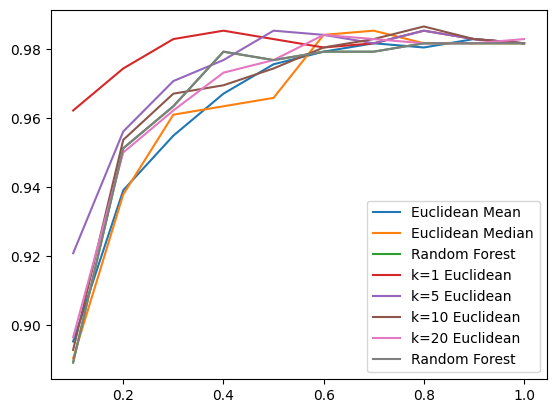

In [58]:
plt.plot(sample_sizes, euc_mean_acc, label = "Euclidean Mean")
plt.plot(sample_sizes, euc_median_acc, label = "Euclidean Median")
plt.plot(sample_sizes, random_forest_acc, label = "Random Forest")
plt.plot(sample_sizes, k_1_euc_mean_acc, label = "k=1 Euclidean")
plt.plot(sample_sizes, k_5_euc_mean_acc, label = "k=5 Euclidean")
plt.plot(sample_sizes, k_10_euc_mean_acc, label = "k=10 Euclidean")
plt.plot(sample_sizes, k_20_euc_mean_acc, label = "k=20 Euclidean")
plt.plot(sample_sizes, random_forest_acc, label = "Random Forest")
plt.legend()
plt.show()

In [74]:
max(k_5_euc_mean_acc)

0.9853658536585366

In [73]:
max(k_1_euc_mean_acc)

0.9853658536585366

In [91]:
lwrf = LocallyWeightedRandomForest(n_estimators=300, max_samples=0.4, max_depth=10)
k_1_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=nearest_k_distance_mean(k=1), distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.975609756097561
Temp:  0.35 , fold acc:  0.975609756097561
Temp:  0.45 , fold acc:  0.975609756097561
Temp:  0.55 , fold acc:  0.975609756097561
Temp:  0.65 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.85 , fold acc:  0.975609756097561
Temp:  1 , fold acc:  0.975609756097561
Temp:  2 , fold acc:  0.975609756097561
Temp:  5 , fold acc:  0.9634146341463414
Temp:  10 , fold acc:  0.9634146341463414
Temp:  15 , fold acc:  0.9634146341463414
Temp:  25 , fold acc:  0.9634146341463414
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.9878048780487805
Temp:  0.25 , fold acc:  0.9878048780487805
Temp:  0.35 , fold acc:  0.9878048780487805
Temp:  0.45 , fold acc:  0.9878048780487805
Temp:  0.55 , fold acc:  0.9878048780487805
Temp:  0.65 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0

In [93]:
euc_mean_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=mean_distance, distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.9634146341463414
Temp:  0.35 , fold acc:  0.9634146341463414
Temp:  0.45 , fold acc:  0.9634146341463414
Temp:  0.55 , fold acc:  0.9634146341463414
Temp:  0.65 , fold acc:  0.9634146341463414
Temp:  0.75 , fold acc:  0.9634146341463414
Temp:  0.75 , fold acc:  0.9634146341463414
Temp:  0.85 , fold acc:  0.9634146341463414
Temp:  1 , fold acc:  0.9634146341463414
Temp:  2 , fold acc:  0.9634146341463414
Temp:  5 , fold acc:  0.9634146341463414
Temp:  10 , fold acc:  0.9634146341463414
Temp:  15 , fold acc:  0.9634146341463414
Temp:  25 , fold acc:  0.9634146341463414
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.9878048780487805
Temp:  0.25 , fold acc:  0.9695121951219512
Temp:  0.35 , fold acc:  0.9695121951219512
Temp:  0.45 , fold acc:  0.9695121951219512
Temp:  0.55 , fold acc:  0.9695121951219512
Temp:  0.65 , fold acc:  0.9573170731707317
Temp:  0.75 , fold acc:  0.9573170731707317
Temp:  0.75 , fo

In [96]:
k_3_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=nearest_k_distance_mean(k=3), distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.975609756097561
Temp:  0.35 , fold acc:  0.975609756097561
Temp:  0.45 , fold acc:  0.975609756097561
Temp:  0.55 , fold acc:  0.975609756097561
Temp:  0.65 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.85 , fold acc:  0.975609756097561
Temp:  1 , fold acc:  0.975609756097561
Temp:  2 , fold acc:  0.9634146341463414
Temp:  5 , fold acc:  0.9634146341463414
Temp:  10 , fold acc:  0.9634146341463414
Temp:  15 , fold acc:  0.9634146341463414
Temp:  25 , fold acc:  0.9634146341463414
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.9817073170731707
Temp:  0.35 , fold acc:  0.9817073170731707
Temp:  0.45 , fold acc:  0.9878048780487805
Temp:  0.55 , fold acc:  0.9878048780487805
Temp:  0.65 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0

In [98]:
k_5_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=nearest_k_distance_mean(k=5), distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.975609756097561
Temp:  0.35 , fold acc:  0.975609756097561
Temp:  0.45 , fold acc:  0.975609756097561
Temp:  0.55 , fold acc:  0.975609756097561
Temp:  0.65 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.85 , fold acc:  0.975609756097561
Temp:  1 , fold acc:  0.975609756097561
Temp:  2 , fold acc:  0.9634146341463414
Temp:  5 , fold acc:  0.9634146341463414
Temp:  10 , fold acc:  0.9634146341463414
Temp:  15 , fold acc:  0.9634146341463414
Temp:  25 , fold acc:  0.9634146341463414
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.9878048780487805
Temp:  0.25 , fold acc:  0.9878048780487805
Temp:  0.35 , fold acc:  0.9878048780487805
Temp:  0.45 , fold acc:  0.9878048780487805
Temp:  0.55 , fold acc:  0.9878048780487805
Temp:  0.65 , fold acc:  0.9878048780487805
Temp:  0.75 , fold acc:  0.9817073170731707
Temp:  0.75 , fold acc:  

In [99]:
dataset_mean_temp_scores = cross_validation_temperature_range(X=train_X, y=train_y, model=lwrf, temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25], distance_agg_func=distance_to_dataset_mean, distance_function=euclidean_distance, folds=5, verbose=True)


Fold Accuracy: 
Temp:  0.15 , fold acc:  0.9817073170731707
Temp:  0.25 , fold acc:  0.975609756097561
Temp:  0.35 , fold acc:  0.975609756097561
Temp:  0.45 , fold acc:  0.975609756097561
Temp:  0.55 , fold acc:  0.975609756097561
Temp:  0.65 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.75 , fold acc:  0.975609756097561
Temp:  0.85 , fold acc:  0.975609756097561
Temp:  1 , fold acc:  0.975609756097561
Temp:  2 , fold acc:  0.975609756097561
Temp:  5 , fold acc:  0.975609756097561
Temp:  10 , fold acc:  0.975609756097561
Temp:  15 , fold acc:  0.975609756097561
Temp:  25 , fold acc:  0.975609756097561
Fold Accuracy: 
Temp:  0.15 , fold acc:  0.975609756097561
Temp:  0.25 , fold acc:  0.9817073170731707
Temp:  0.35 , fold acc:  0.9817073170731707
Temp:  0.45 , fold acc:  0.9817073170731707
Temp:  0.55 , fold acc:  0.9817073170731707
Temp:  0.65 , fold acc:  0.9817073170731707
Temp:  0.75 , fold acc:  0.9817073170731707
Temp:  0.75 , fold acc:  0.981

In [69]:
k_1_temp_scores

array([0.98292683, 0.98292683, 0.98292683, 0.98292683, 0.97804878,
       0.97195122, 0.9695122 , 0.9695122 , 0.9695122 ])

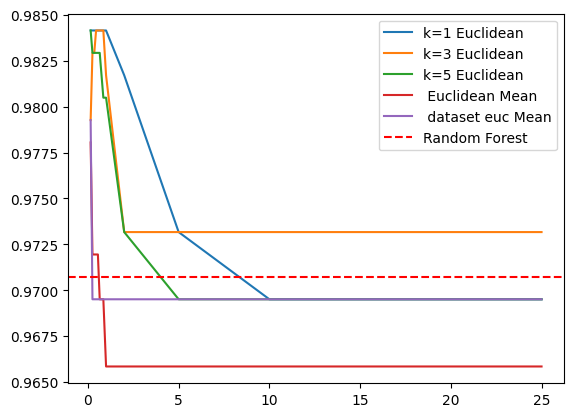

In [102]:
temperature_list=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.75,0.85, 1, 2, 5, 10, 15, 25]


# Baseline with random forest
model = RandomForestClassifier(random_state=1, n_estimators=300, max_samples=0.4, max_depth=10)
random_forest_cross_eval = np.mean(cross_val_score(model, train_X, train_y, cv=5))


plt.plot(temperature_list, k_1_temp_scores, label = "k=1 Euclidean")
plt.plot(temperature_list, k_3_temp_scores, label = "k=3 Euclidean")
plt.plot(temperature_list, k_5_temp_scores, label = "k=5 Euclidean")

plt.plot(temperature_list, euc_mean_temp_scores, label = " Euclidean Mean"  )
plt.plot(temperature_list, dataset_mean_temp_scores, label = " dataset euc Mean"  )

plt.axhline(y = random_forest_cross_eval, color = 'r', linestyle = '--', label = "Random Forest") 
plt.legend()
plt.show()

In [55]:
max(k_10_euc_mean_acc)

0.9865853658536586

In [15]:
cross_validation(X=train_X, y=train_y, model=lwrf, temperature=1.0, distance_agg_func=mean_distance, distance_function=euclidean_distance, folds=5, verbose=True)

Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9451219512195121
Fold Accuracy:  1.0


0.9817073170731707

In [16]:
cross_validation(X=train_X, y=train_y, model=lwrf, temperature=2.0, distance_agg_func=mean_distance, distance_function=euclidean_distance, folds=5, verbose=True)

Fold Accuracy:  0.975609756097561
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  1.0


0.9829268292682926

In [33]:
cross_validation(X=train_X, y=train_y, model=lwrf, temperature=2.0, distance_agg_func=nearest_k_distance_mean(k=10), distance_function=euclidean_distance, folds=5, verbose=True)

Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9939024390243902
Fold Accuracy:  0.9451219512195121
Fold Accuracy:  1.0


0.9829268292682928

In [34]:
cross_validation(X=train_X, y=train_y, model=lwrf, temperature=2.0, distance_agg_func=nearest_k_distance_mean(k=1), distance_function=euclidean_distance, folds=5, verbose=True)

Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9817073170731707
Fold Accuracy:  0.9878048780487805
Fold Accuracy:  0.9634146341463414
Fold Accuracy:  0.9878048780487805


0.9817073170731707